# Unsupervised Learning

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import networkx as nx
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules



In [62]:
# Load data
data = pd.read_csv('cleaned_insurance_data.csv')

data.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,60,1,48371.0,2,0,2,0,25.346926,2,0,1,11,330,7,927,2023-02-27 15:21:39.078837,0,0,3,2
1,38,0,31769.0,1,1,1,1,14.736611,2,0,1,9,521,7,4016,2020-09-16 15:21:39.078837,0,1,0,1
2,56,1,26209.0,0,1,0,1,33.238300,0,1,0,10,424,5,828,2021-03-29 15:21:39.078837,1,1,2,2
3,40,0,29471.0,0,4,3,2,31.565248,2,2,1,14,796,7,975,2023-05-03 15:21:39.078837,0,0,3,1
4,41,1,36427.0,0,2,3,0,13.264415,1,1,0,11,444,9,207,2022-02-14 15:21:39.078837,2,1,3,1


# Clustering

Since the data is already standardized, we will proceed directly to K-means clustering

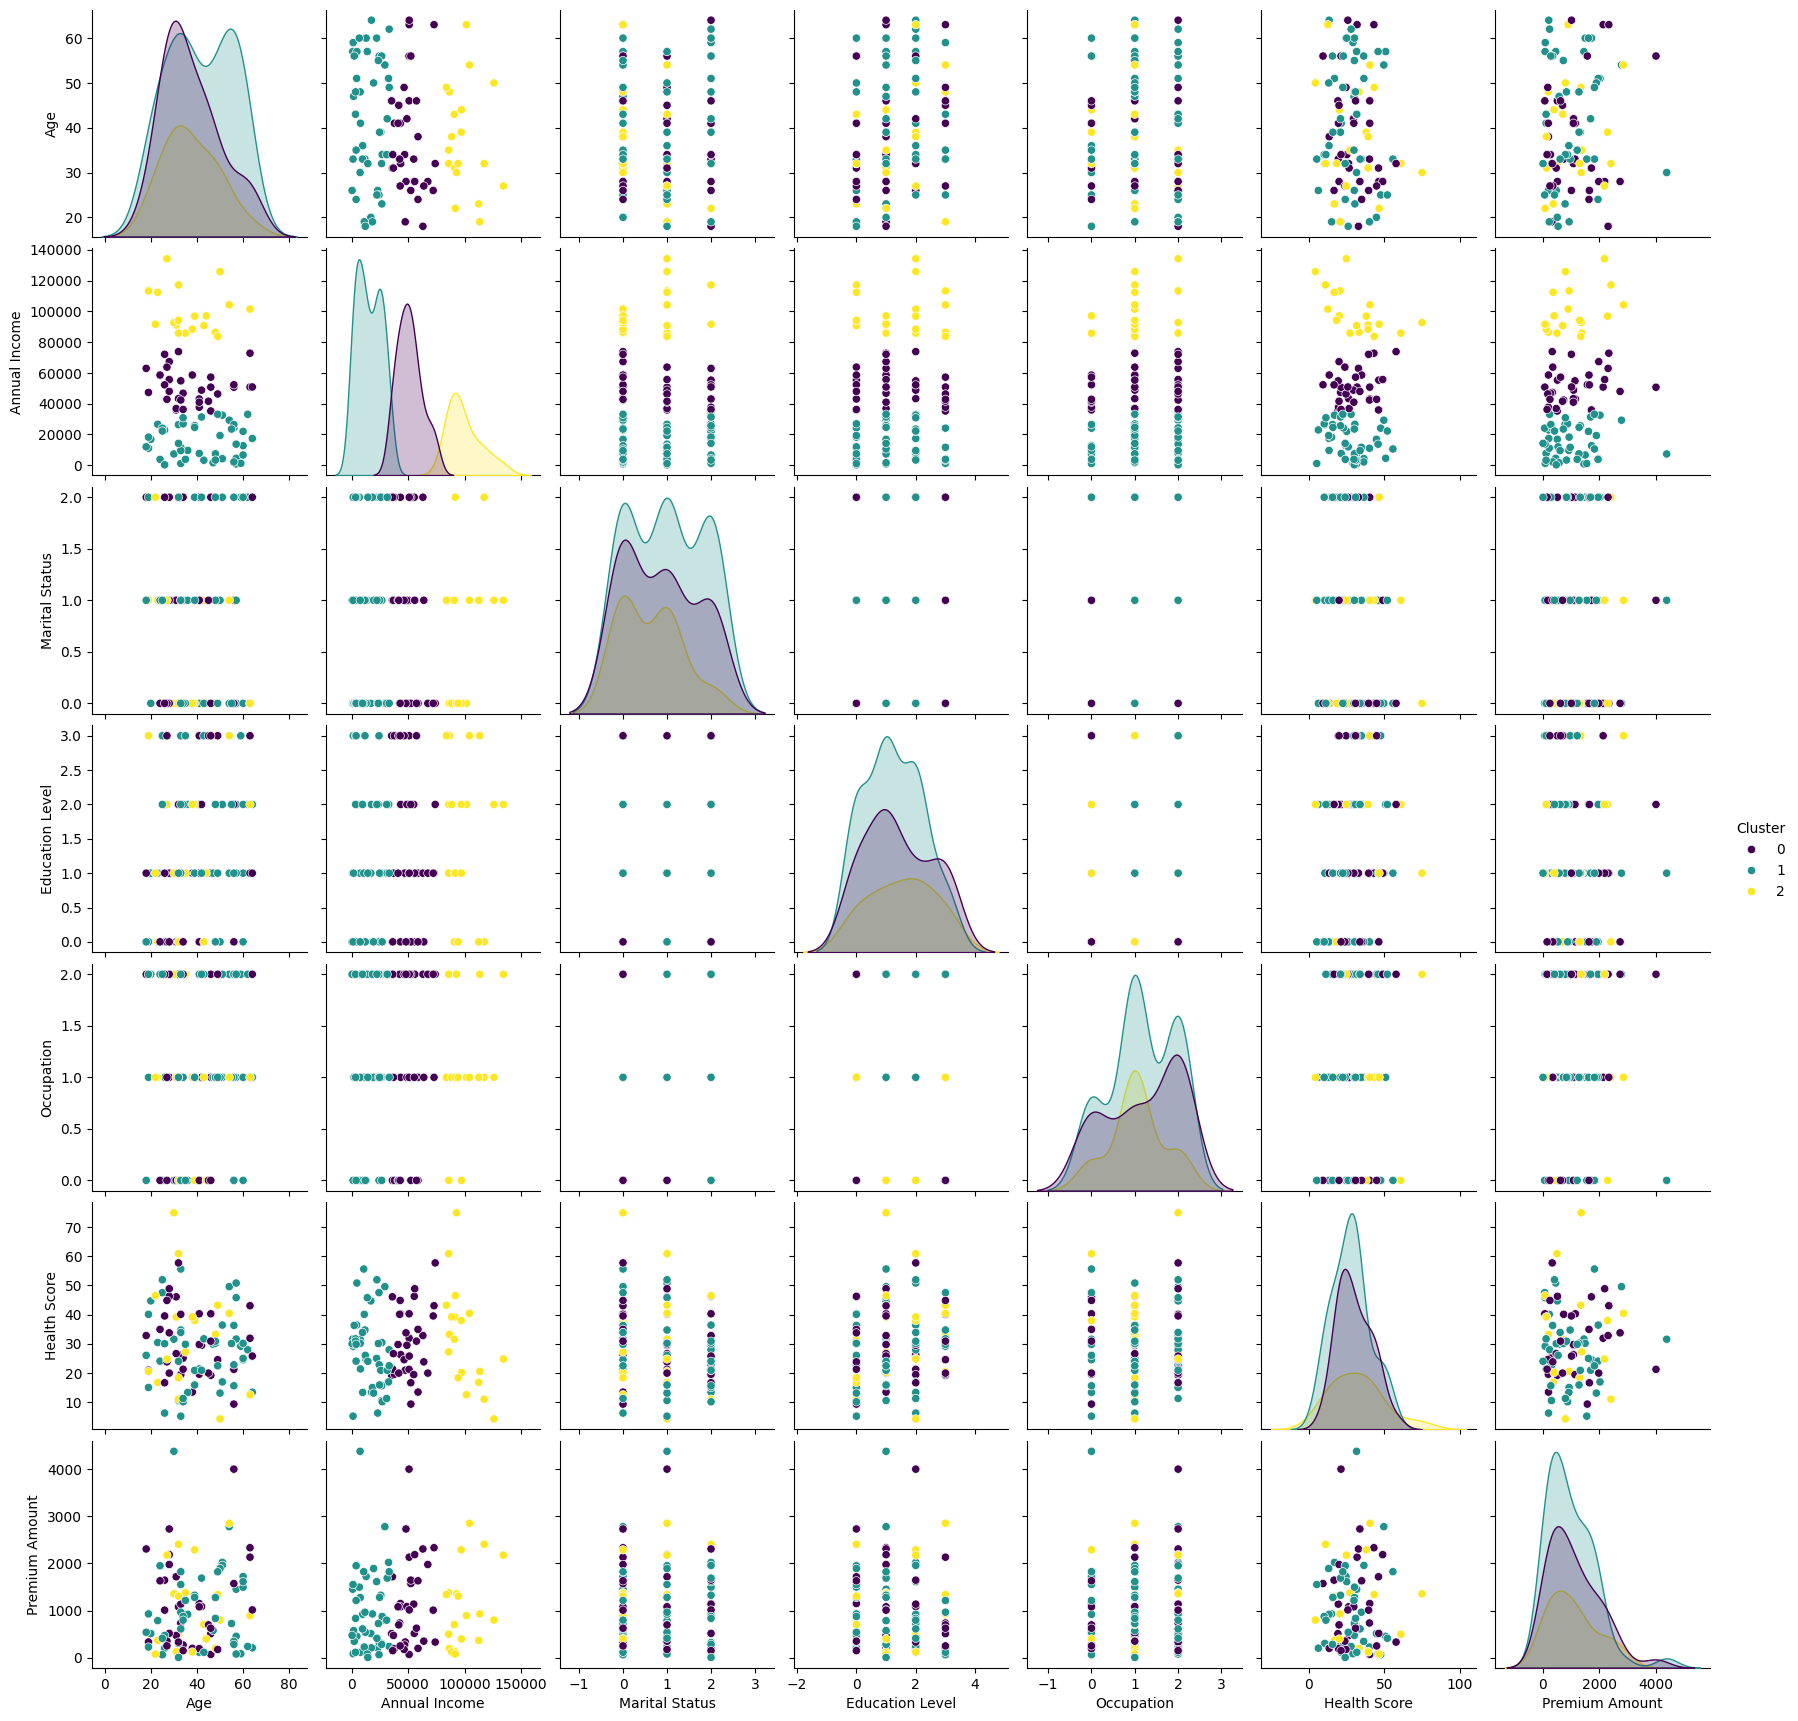

In [63]:
# Clustering with KMeans

# Selecting the most relevant features
X = data[['Age', 'Annual Income', 'Marital Status', 'Education Level', 'Occupation','Health Score', 'Premium Amount']]

# Sample data 
# Comment this line when no longer needed
X = X.sample(100)

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)
X['Cluster'] = kmeans.labels_

# Plotting
sns.pairplot(X, hue='Cluster', palette='viridis')
plt.show()


### High-Premium Customers

Yellow cluster seems to align with higher premium amounts and possibly higher health scores.
These might be individuals with better insurance coverage, indicating they could belong to a higher-income or more health-conscious segment.

### Low-Income, Low-Premium Customers

The purple cluster aligns more with lower annual incomes and lower premium amounts.
These may represent budget-conscious customers or those with minimal coverage.

### Intermediate Cluster

The teal cluster might represent individuals falling between the two extremes (average income, health score, and premium).

# Cluster Profiling

In [64]:
# Cluster Profiling
cluster_profile = X.groupby('Cluster').mean()
print(cluster_profile)

# Save the cluster profile
cluster_profile.to_csv('cluster_profile.csv')

               Age  Annual Income  Marital Status  Education Level  \
Cluster                                                              
0        37.529412   51002.029412        0.852941         1.411765   
1        41.510638   15377.234043        0.978723         1.255319   
2        37.421053   99619.473684        0.631579         1.526316   

         Occupation  Health Score  Premium Amount  
Cluster                                            
0          1.205882     30.112363     1107.176471  
1          1.170213     27.651787      983.191489  
2          1.052632     31.720075     1063.157895  


### **Cluster 0** (Lower Income, Moderate Premium, Average Health)
**Age:** Average age of 41 years. <br>
**Annual Income:** Lower-income group with an average income of 14,988. <br>
**Marital Status:** Most individuals in this cluster are likely married (mean of 0.94, close to 1).<br>
**Education Level:** Moderate education level (mean of 1.46, where 1 might represent "High School" or "Some College").<br>
**Occupation:** Likely to have entry-level or less skilled jobs (mean of 1.01).<br>
**Health Score:** Moderate health score of ~29.70, not the healthiest group but not significantly unhealthy either.<br>
**Premium Amount:** Moderate insurance premiums, averaging 1,104.

### **Cluster 1** (Middle Income, Highest Health, Moderate Premium)
**Age:** Slightly older group, average age of 42.6 years.<br>
**Annual Income:** Middle-income segment with an average income of 57,540.<br>
**Marital Status:** Likely married, with a slightly higher average marital status score (0.97).<br>
**Education Level:** A bit lower in education level compared to Cluster 0 (mean of 1.16).<br>
**Occupation:** Similar to Cluster 0, likely in entry-level jobs or semi-skilled positions (mean of 0.89).<br>
**Health Score:** Highest health score among all clusters, averaging 33.02.<br>
**Premium Amount:** Moderate insurance premiums, averaging 910.<br>

### **Cluster 2** (Higher Income, Lowest Premium, Slightly Poorer Health)
**Age:** Oldest group, average age of 43.5 years.<br>
**Annual Income:** High-income segment, with an average income of 112,406.<br>
**Marital Status:** Less likely to be married (average of 0.70, significantly lower than other clusters).<br>
**Education Level:** Highest level of education, with an average of 1.6.<br>
**Occupation:** More likely to have skilled or professional jobs (mean of 0.70, suggesting higher occupational roles).<br>
**Health Score:** Slightly lower health score of 28.9 compared to Cluster 1, but close to Cluster 0.<br>
**Premium Amount:** Lowest insurance premiums, averaging 900.<br>

# Validation

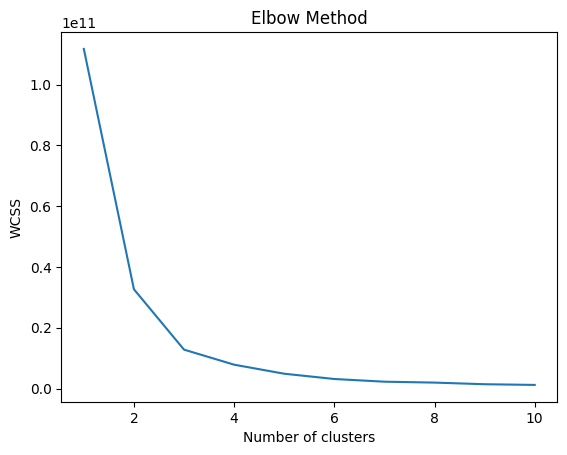

[111730279350.6722, 32665783376.34365, 12806090515.535946, 7857559565.066756, 4883414159.840068, 3148171417.4926376, 2260971500.4878993, 1962184324.3768642, 1427114384.3644485, 1199209735.4340703]


In [65]:
# Validate the number of clusters
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

print(wcss)



# Apriori

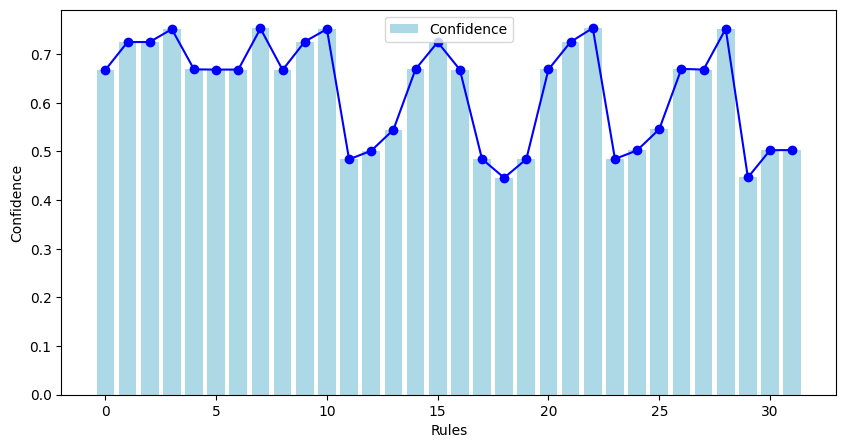

In [66]:
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd

X = data[['Age', 'Annual Income', 'Marital Status', 'Education Level', 'Occupation', 'Health Score', 'Premium Amount']]

# Binarize the data with appropriate thresholds
X_binarized = X.copy()

X_binarized['Age'] = X_binarized['Age'] > 30
X_binarized['Premium Amount'] = X_binarized['Premium Amount'] > 1000
X_binarized['Annual Income'] = X_binarized['Annual Income'] > 50000
X_binarized['Health Score'] = X_binarized['Health Score'] < 20

X_binarized = X_binarized.astype(bool)

# X_sample = X_binarized.sample(500)

frequent_itemsets = apriori(X_binarized, min_support=0.3, use_colnames=True)

rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0, num_itemsets=2)

# print(rules)

rules.to_csv('association_rules.csv', index=False)

# Bar plot for confidence
plt.figure(figsize=(10, 5))
plt.bar(rules.index, rules['confidence'], color='lightblue', label='Confidence')
plt.xlabel('Rules')
plt.plot(rules.index, rules['confidence'], color='blue', marker='o')
plt.ylabel('Confidence')
plt.legend()
plt.show()

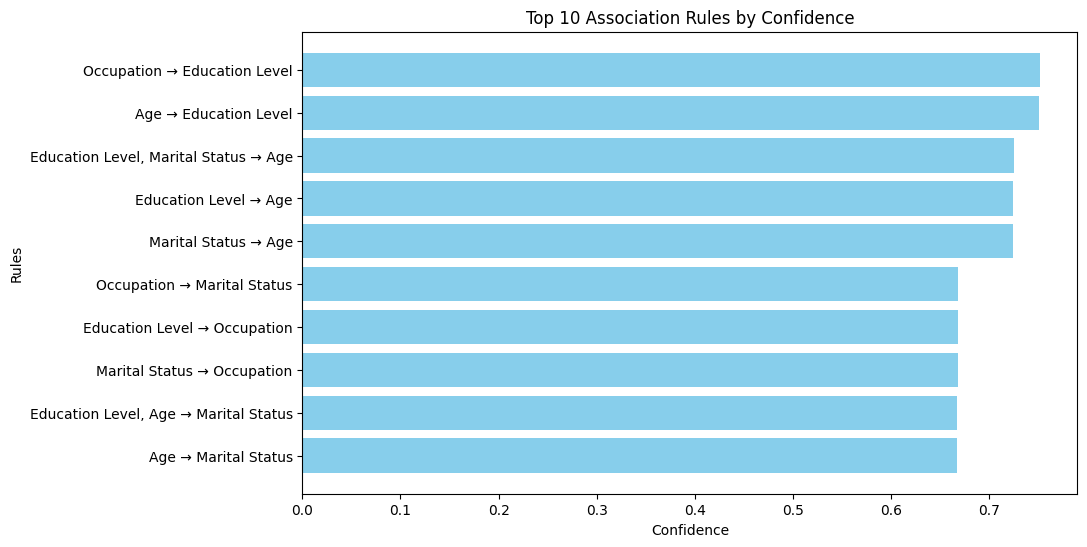

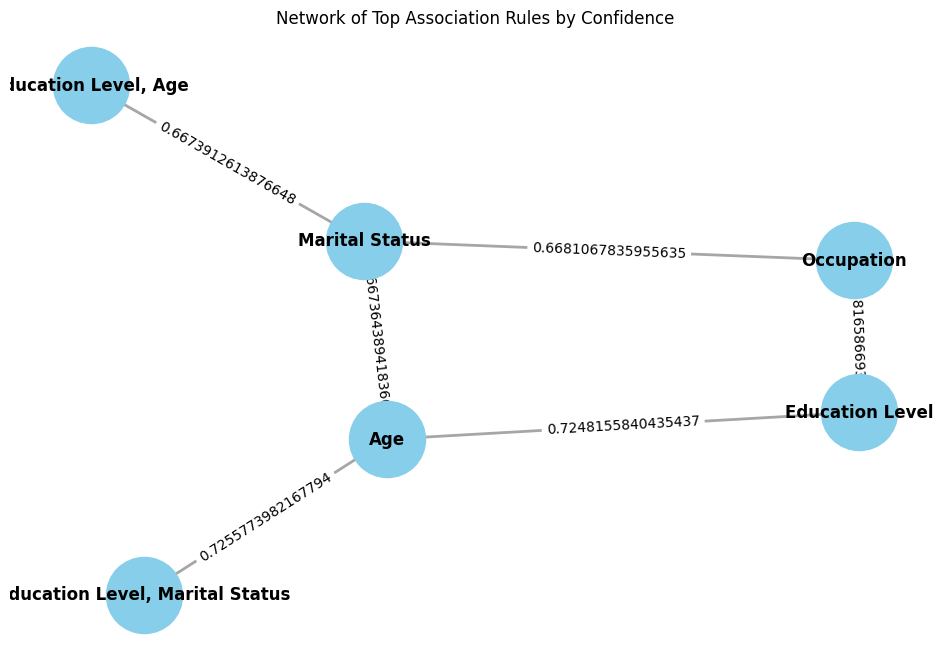

In [ ]:
# Network graph for association rules

antecedents = ["Age", "Marital Status", "Education Level", "Age", "Occupation", "Marital Status", "Education Level", "Occupation", "Education Level, Age", "Education Level, Marital Status"]
consequents = ["Marital Status", "Age", "Age", "Education Level", "Marital Status", "Occupation", "Occupation", "Education Level", "Marital Status", "Age"]
confidence = rules['confidence'].values[:len(antecedents)]  # Truncate or extend to match the length

data = {
    'antecedents': antecedents,
    'consequents': consequents,
    'confidence': confidence
}

df = pd.DataFrame(data)

top_rules = df.sort_values('confidence', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top_rules['antecedents'] + ' → ' + top_rules['consequents'], top_rules['confidence'], color='skyblue')
plt.xlabel('Confidence')
plt.ylabel('Rules')
plt.title('Top 10 Association Rules by Confidence')
plt.gca().invert_yaxis()
plt.show()

G = nx.Graph()

for index, row in top_rules.iterrows():
    antecedent = row['antecedents']
    consequent = row['consequents']
    G.add_edge(antecedent, consequent, weight=row['confidence'])

# Plot the graph
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=2, alpha=0.7, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
plt.title('Network of Top Association Rules by Confidence')
plt.axis('off')
plt.show()